In [ ]:
# Install all the packages
pip install matplotlib
pip install pandas
pip install scikit-image
pip install openpyxl

In [23]:
# Import packages 
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
import pandas as pd
from skimage.io import imread
from cellpose import plot, utils, io
from skimage.morphology import dilation, square
from skimage.measure import regionprops
from scipy.ndimage import binary_dilation
from Hexagonality_score import hexagonality_score
from Process_ROI import process_roi

In [24]:
# Import the file and prepare mask data in the folder of the pipeline
FILEPATH = r"Put the filepath of the picture"
DATANAME = 'Example_Cell_Borders'

data = np.load(os.path.join(FILEPATH, DATANAME + '_seg.npy'), allow_pickle=True).item() # It takes the file name and add the file extension at the end.
  
all_mask=copy.copy(data['masks'])
analyze_masks = utils.remove_edge_masks(data['masks'], change_index=True) # It removes the cell in the edge.

# mask is an image for each segment in the image assigned numbers from 0 to 255
plt.imsave("analyze_masks.png", analyze_masks, cmap='gray') # save the data in the same path of the pipeline
plt.close()

num_regions = np.max(analyze_masks)


In [25]:
# parameter calculation for each ROI
data = process_roi(all_mask, num_regions, hexagonality_score)

In [26]:
# Initialize Region dictionary with 2D arrays for each property, using the same shape as analyze_masks

Region = {
    'Area': np.zeros_like(analyze_masks, dtype=float),
    'Perimeter': np.zeros_like(analyze_masks, dtype=float),
    'Neighbor': np.zeros_like(all_mask, dtype=float),
    'HexAve': np.zeros_like(analyze_masks, dtype=float),
    'HexSt': np.zeros_like(analyze_masks, dtype=float),
    'PolyAve': np.zeros_like(analyze_masks, dtype=float),
    'Aspect_Ratio': np.zeros_like(analyze_masks, dtype=float),
    'Circularity': np.zeros_like(analyze_masks, dtype=float)
}

# Map each property value to its corresponding pixels in the 2D analyze_masks

for region_id in range(1, num_regions + 1):
    region_pixels = (analyze_masks == region_id)  # Mask pixels corresponding to the current region
    
    # Assign each property to the appropriate region in the Region matrices
    Region['Area'][region_pixels] = data['area'][region_id - 1] *0.006769 #convert pixels to um2
    Region['Perimeter'][region_pixels] = data['perimeter'][region_id - 1]
    Region['Neighbor'][region_pixels] = data['neighbor_counts'][region_id - 1]
    Region['HexAve'][region_pixels] = data['hexAve'][region_id - 1]
    Region['HexSt'][region_pixels] = data['hexSd'][region_id - 1]
    Region['PolyAve'][region_pixels] = data['polyAve'][region_id - 1]
    Region['Aspect_Ratio'][region_pixels] = data['aspect_ratio'][region_id - 1]
    Region['Circularity'][region_pixels] = data['circularity'][region_id - 1]


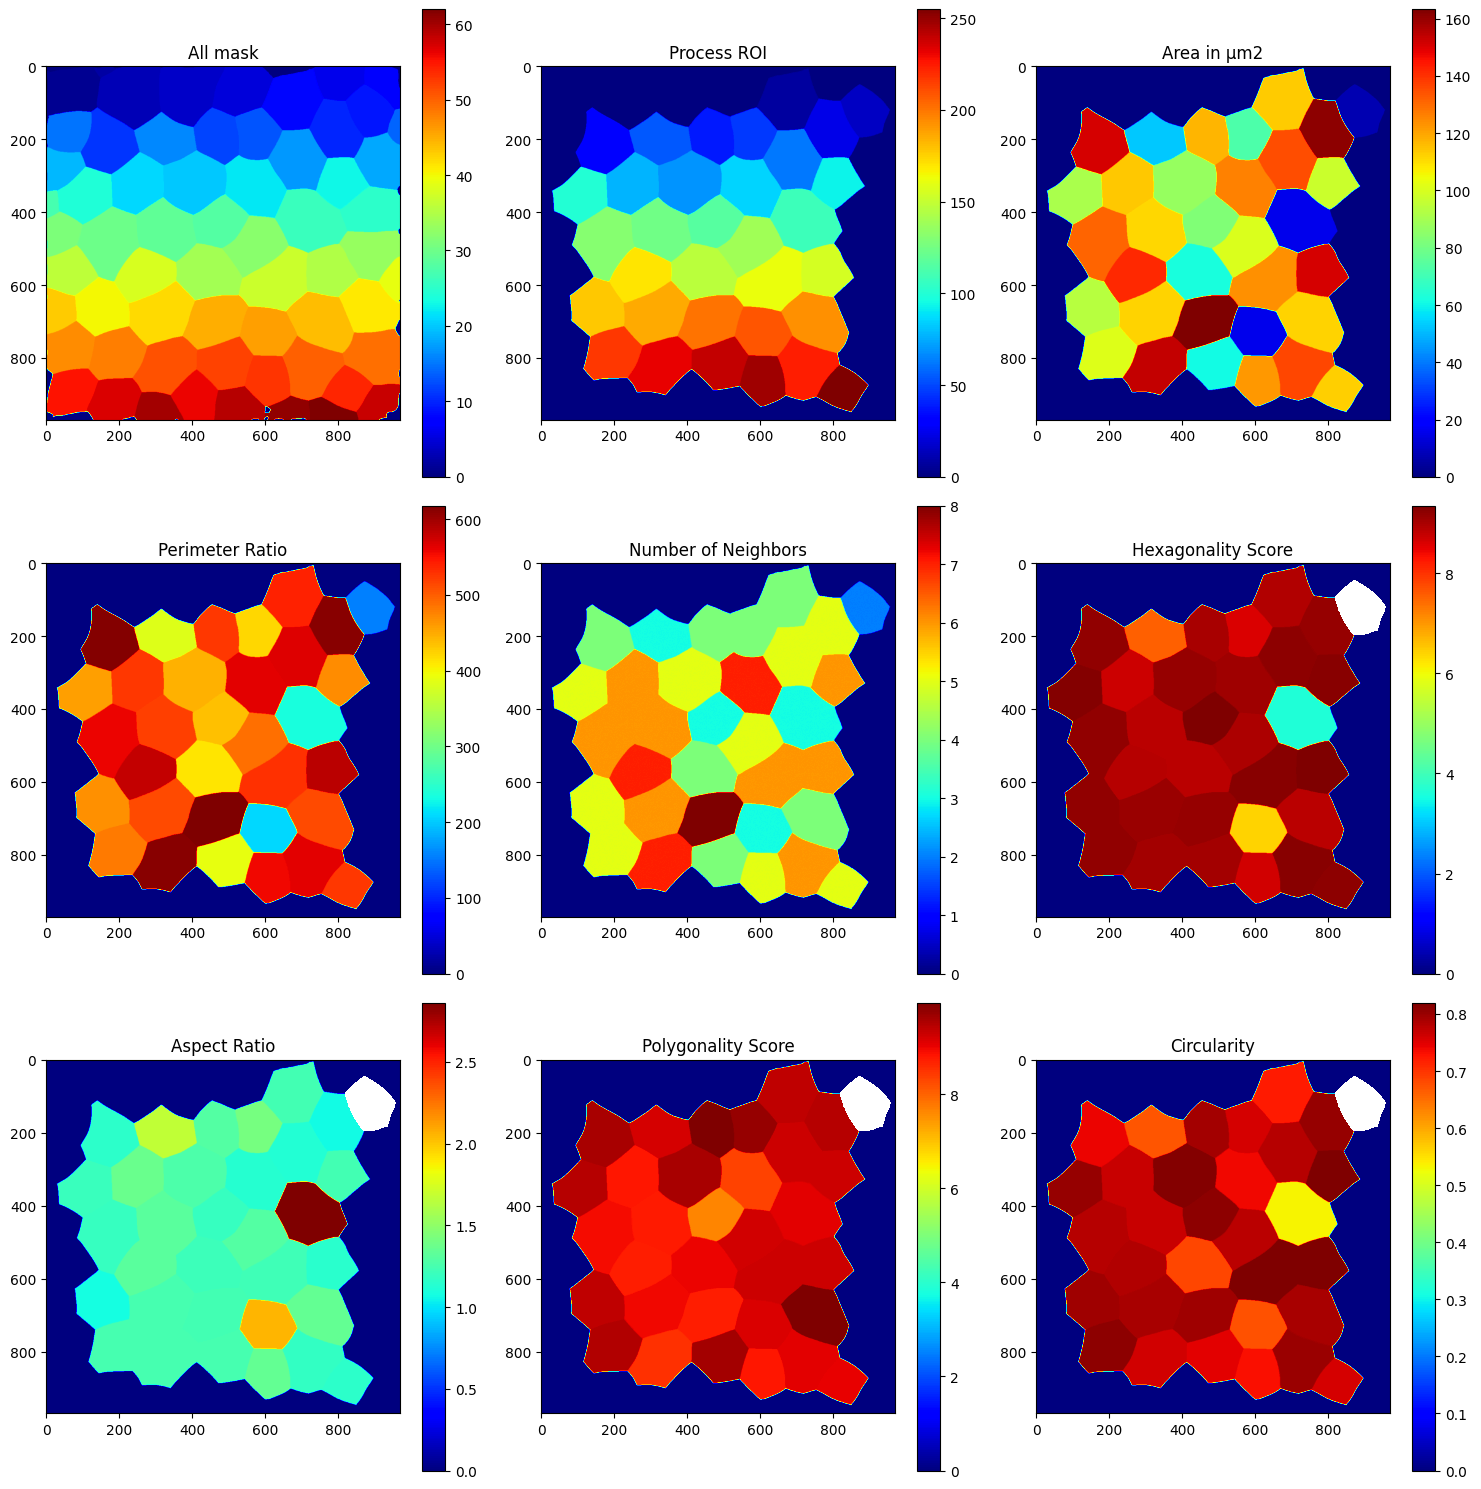

In [27]:
# Plot everything
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Subplots with individual colorbars

im0 = axes[0, 0].imshow(all_mask, cmap='jet')
axes[0, 0].set_title('All mask')
fig.colorbar(im0, ax=axes[0, 0])

im1 = axes[0, 1].imshow(mask, cmap='jet')
axes[0, 1].set_title('Process ROI')
fig.colorbar(im1, ax=axes[0, 1])

im2 = axes[0, 2].imshow(Region['Area'], cmap='jet')
axes[0, 2].set_title('Area in µm2')
fig.colorbar(im2, ax=axes[0, 2])

im3 = axes[1, 0].imshow(Region['Perimeter'], cmap='jet')
axes[1, 0].set_title('Perimeter Ratio')
fig.colorbar(im3, ax=axes[1, 0])

im4 = axes[1, 1].imshow(Region['Neighbor'], cmap='jet')
axes[1, 1].set_title('Number of Neighbors')
fig.colorbar(im4, ax=axes[1, 1])

im5 = axes[1, 2].imshow(Region['HexAve'], cmap='jet')
axes[1, 2].set_title('Hexagonality Score')
fig.colorbar(im5, ax=axes[1, 2])

im6 = axes[2, 0].imshow(Region['Aspect_Ratio'], cmap='jet')
axes[2, 0].set_title('Aspect Ratio')
fig.colorbar(im6, ax=axes[2, 0])

im7 = axes[2, 1].imshow(Region['PolyAve'], cmap='jet')
axes[2, 1].set_title('Polygonality Score')
fig.colorbar(im7, ax=axes[2, 1])

im8 = axes[2, 2].imshow(Region['Circularity'], cmap='jet')
axes[2, 2].set_title('Circularity')
fig.colorbar(im8, ax=axes[2, 2])


# Adjust layout and display
plt.tight_layout()
plt.show()


In [28]:
# Save all the values in excel sheet

data_dict = {
    "Number of neighbors" : data['neighbor_counts'],
    "Area": data['area'],
    "Perimeter": data['perimeter'],
    "Aspect_Ratio": data['aspect_ratio'],
    "HexAve": data['hexAve'],
    "HexSd": data['hexSd'],
    "PolyAve": data['polyAve']
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data_dict)

# Save the DataFrame to an Excel file
# Get rid of the NaN
df_cleaned = df.dropna() 

file_path = os.path.join(FILEPATH, 'Results.xls')

# Save the DataFrame as an Excel file
df_cleaned.to_excel(file_path, index=False, engine="openpyxl")

print(f"Data saved successfully at {file_path}")

Data saved successfully at \\fshomes\kgenc$\Downloads\Results.xls
